# Capstone 1 Group 4 Notebook

## Importing necessary libraries

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import csv
import scipy.stats as stats
%matplotlib inline

## Loading data

In [84]:
tn_movie_budgets = pd.read_csv('tn.movie_budgets.csv')
tmdb_csv = pd.read_csv('tmdb.movies.csv')

conn = sqlite3.connect('im.db')

Sqlite_df = pd.read_sql("""
select *
from movie_basics
join movie_ratings
using (movie_id)
join movie_akas
using (movie_id)
group by primary_title
;
""", conn)

## Cleaning

### Converting genre IDs to genre names

In [85]:
# Creating dictionary to turn genre IDs into genres
comment = """Action          28
Adventure       12
Animation       16
Comedy          35
Crime           80
Documentary     99
Drama           18
Family          10751
Fantasy         14
History         36
Horror          27
Music           10402
Mystery         9648
Romance         10749
Science Fiction 878
TV Movie        10770
Thriller        53
War             10752
Western         37"""
id_to_genre = {line.split(' ')[-1]:line.split(' ')[0].lower() for line in comment.split('\n')}

# Creating function to transform genre IDs
def convert_ids(line):
    return ','.join(sorted([id_to_genre.get(x.strip(), x.strip()) for x in line[1:-1].split(',')]))

# Transforming and further cleaning genre IDs
tmdb_csv['genre'] = tmdb_csv.genre_ids.apply(convert_ids)
tmdb_csv.drop(columns=["Unnamed: 0", 'id'], inplace=True)
tmdb_csv['release_date'] = pd.to_datetime(tmdb_csv.release_date)
tmdb_csv['title'] = tmdb_csv.title.str.lower()

#Cleaning tn movie budget data
tn_movie_budgets.drop(columns=['id'], inplace=True)
tn_movie_budgets['movie'] = tn_movie_budgets.movie.str.lower()
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets.release_date)
tn_movie_budgets['total_gross'] = tn_movie_budgets['domestic_gross'].str.lstrip('$').str.replace(',', '').astype(np.int64) + tn_movie_budgets['worldwide_gross'].str.lstrip('$').str.replace(',', '').astype(np.int64) 
tn_movie_budgets['both_gross'] = tn_movie_budgets.worldwide_gross.str.lstrip('$').str.replace(',', '').astype(np.int64)
tn_movie_budgets['pb'] = tn_movie_budgets['production_budget'].str.lstrip('$').str.replace(',', '').astype(np.int64)
tn_movie_budgets['ropb'] = (tn_movie_budgets.both_gross / tn_movie_budgets.pb)
tn_movie_budgets.sort_values(by=['ropb'], ascending=False, inplace=True)

#Merging both datasets
budget_genre = tn_movie_budgets.merge(tmdb_csv, left_on=['movie', 'release_date'], right_on=['title', 'release_date'], how='inner').drop_duplicates()

## Create visualization for return on production budget for genres

### Top single genres for return on production budget

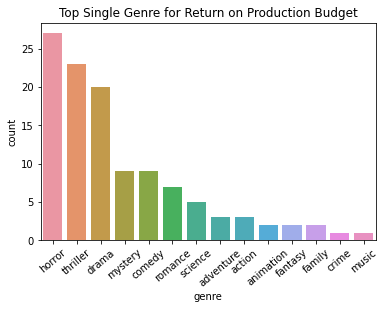

In [86]:
genre_split = budget_genre.iloc[:50].genre.str.split(',').explode('genre').value_counts()
genre_split_df = genre_split.reset_index()
genre_split_df.columns = ['genre', 'count']
genre_combined = budget_genre.iloc[:50].genre.value_counts()
genre_combined_df = genre_combined.reset_index()
genre_combined_df.columns = ['genre', 'count']
sns.barplot(data=genre_split_df, x='genre', y='count');
plt.title('Top Single Genre for Return on Production Budget')
plt.xticks(rotation=40);

### Top combined genres for return on production budget

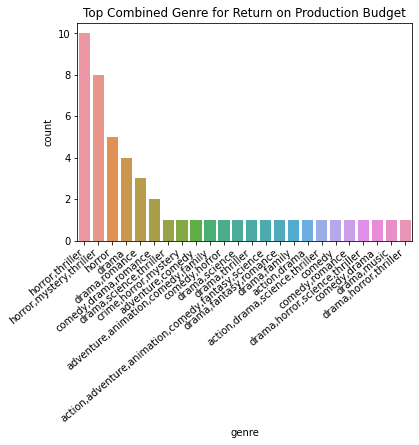

In [87]:
sns.barplot(data=genre_combined_df, x='genre', y='count')
plt.title('Top Combined Genre for Return on Production Budget')
plt.xticks(rotation=40, horizontalalignment='right');

## Top combined genres profit

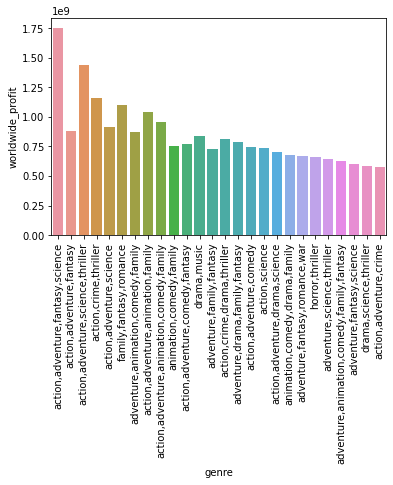

In [88]:
budget_genre['production_budget'] = budget_genre['production_budget'].str.replace(',', '').str.replace('$', '')
budget_genre['worldwide_gross'] = budget_genre['worldwide_gross'].str.replace(',', '').str.replace('$', '')
budget_genre['worldwide_profit'] = budget_genre['worldwide_gross'].fillna(0).astype('int64') - budget_genre['production_budget'].fillna(0).astype('int64')

budget_genre = budget_genre.sort_values('worldwide_profit', ascending= False).drop_duplicates(subset=['movie'])[:50]

sns.barplot(data = budget_genre, x = budget_genre.genre, y=budget_genre.worldwide_profit, ci = None);
#sns.set(rc={'figure.figsize':(7,15)})
plt.xticks(rotation=90);

### Descriptive Analytics

## Goals

## Methods

## Results

## Closing connection

In [89]:
conn.close()